<a href="https://colab.research.google.com/github/dondoC34/SalesForecast/blob/master/DMTM_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Text Mining Project
Sales Forecast
The training data are contained in train.csv file, let's give a look at how the data are structured and the available features.




In [0]:
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
from scipy.stats import pearsonr;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf;
from statsmodels.stats.diagnostic import het_white;
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from itertools import combinations
warnings.filterwarnings('ignore')

In [0]:
def MAPE(y_true, y_pred):
  y_t = np.array(y_true)
  y_p = np.array(y_pred)
  return round(np.mean(np.abs(y_t - y_p) / y_t), 3)

In [4]:
sales_data = pd.read_csv('/content/drive/My Drive/DMTM_Project_Data/train.csv')
for column in sales_data.columns:
  print(column)

Unnamed: 0
sku
pack
size (GM)
brand
price
POS_exposed w-1
volume_on_promo w-1
sales w-1
scope
target


The binary "scope" feature denotes which product we are required to predict their sales. For now we can consider only those products, identified by their SKUs (codes). 

In [5]:
sales_data = sales_data[sales_data["scope"] == 1]
sales_data.groupby("sku").describe()

size (GM)                        ...    target                    
         count    mean           std  ...       50%       75%       max
sku                                   ...                              
144      133.0  114.23  3.138208e-13  ...   38457.0   64206.0  127418.0
546      133.0  114.23  3.138208e-13  ...   88557.0  140448.0  266919.0
549      133.0  114.23  3.138208e-13  ...   45176.0   84176.0  179886.0
554      133.0  114.23  3.138208e-13  ...  138360.0  206982.0  392180.0
686      133.0  125.65  2.139687e-13  ...   41500.0   67126.0  146671.0
688      133.0  125.65  2.139687e-13  ...   39185.0   59194.0  121177.0
1027     133.0  114.23  3.138208e-13  ...   68544.0  108807.0  237531.0
1035     133.0  114.23  3.138208e-13  ...   46158.0   77317.0  170760.0
1051     133.0  125.65  2.139687e-13  ...   21979.0   38686.0   66679.0
1058     133.0  125.65  2.139687e-13  ...   36281.0   58225.0  117791.0
1065     133.0  125.65  2.139687e-13  ...  104824.0  152681.0  280918.0
1206     133.0  125.65  2.139687e-13  ...   54660.0   80842.0  145037.0

[12 rows x 56 columns]

The fact that, for each sku code, we have exactly 133 samples available makes me think that the time series of sales, for each product, is composed by 133 samples and there are no missing dates. Let verify this point through a simple plot for sku 1027, for the target feature. Before to procede, we have to set the date as the index of each sample

In [0]:
for i, row in sales_data.iterrows():
  date = row["Unnamed: 0"]
  date_wo_day_of_week = date[3:] # Remove WE since all days of the week are the same
  sales_data.at[i, "Unnamed: 0"] = date_wo_day_of_week

sales_data["Unnamed: 0"] = pd.to_datetime(sales_data["Unnamed: 0"])

In [0]:
sales_data.set_index(sales_data["Unnamed: 0"], inplace=True)

In [0]:
sales_data.drop(columns="Unnamed: 0", axis=1, inplace=True)
sales_data.index.rename("date", inplace=True)

Consider, as an example, the product with **sku** = 1027:

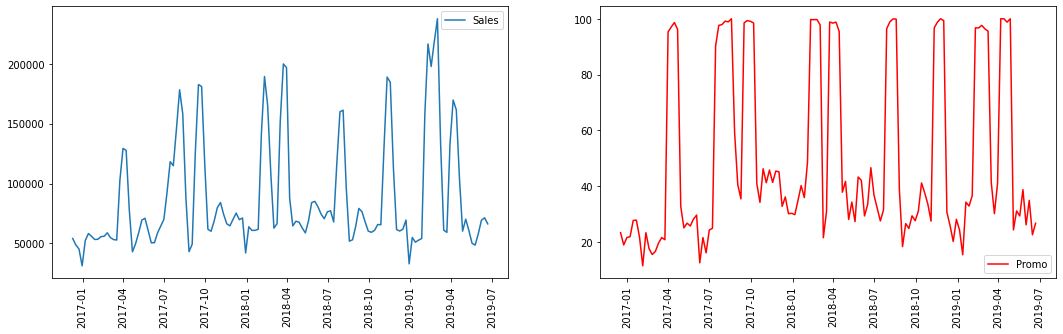

In [9]:
fig,ax = plt.subplots(2,1,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(sales_data[sales_data["sku"] == 1027]["target"], label="Sales");
plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
plt.plot(sales_data[sales_data["sku"] == 1027]["volume_on_promo w-1"], label="Promo", color="red");
plt.xticks(rotation=90)
plt.legend();

It looks like that the peaks of promo products corresponds, as one may expect, to peaks of sales on the same week. **A seasonality of sales and promos can be easily noticed**. Let's then check the pearson correlation between these two time series:

In [10]:
sales_data_1027 = sales_data[sales_data["sku"] == 1027]
sales_data_1027 = sales_data_1027.dropna()
print("Pearson Coeff for sales on week W and promo volume for week W-1:", pearsonr(sales_data_1027["target"], sales_data_1027["volume_on_promo w-1"])[0])

Pearson Coeff for sales on week W and promo volume for week W-1: 0.6696570909947503


The Pearson coeff is not so high highlighting the fact that the two time series are not heavily correlated. This can be due to the fact that the sales and the promotion are referring to two different weeks. In particular, sales are on week W whereas the promotion takes place on week W-1. If we compare indeed the sales and the promotion on week W-1 the new Pearson coeff is:

In [11]:
print("Pearson Coeff for sales on week W-1 and promo volume for week W-1:", pearsonr(sales_data_1027["sales w-1"], sales_data_1027["volume_on_promo w-1"])[0])

Pearson Coeff for sales on week W-1 and promo volume for week W-1: 0.8551663708800589


We may wonder that **the planned price for week W could influence the sales on week W**, that is the "target" we have to predict. In particular, the planned price can be viewed as a reflection of a possible promotion on the next week. Let's check this possible correlation through some plots:

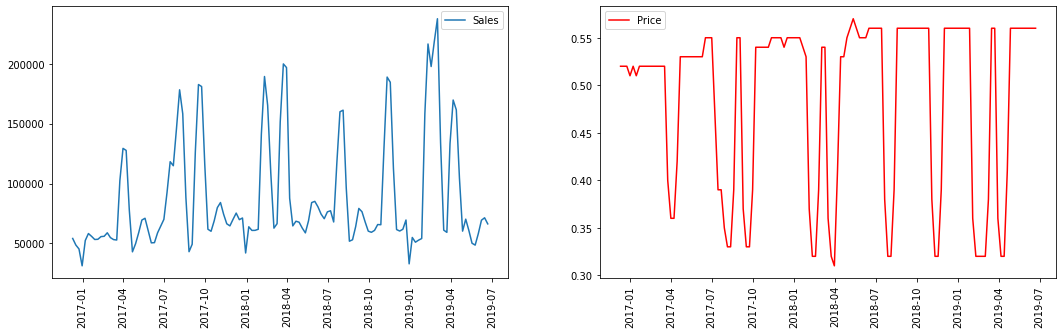

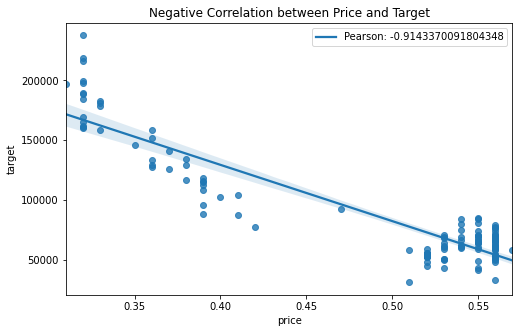

In [12]:
fig,ax = plt.subplots(2,2,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(sales_data[sales_data["sku"] == 1027]["target"], label="Sales");
plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
plt.plot(sales_data[sales_data["sku"] == 1027]["price"], label="Price", color="red");
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(8, 5))
sns.regplot(x="price", y="target", data=sales_data[sales_data["sku"] == 1027])
plt.title("Negative Correlation between Price and Target");
p_coeff = pearsonr(sales_data[sales_data["sku"] == 1027]["price"], sales_data[sales_data["sku"] == 1027]["target"])
plt.legend(["Pearson: " + str(p_coeff[0])]);


It looks like that for low prices people buy more stuff (the negative correlation is clear also from the two plots of the corresponding time series). The planned price provides then us a useful insight on the possible amount of sales to be forecasted.
It has to be taken into account that the **price** feature is the planned price for the next week, that is, the week for which we have to predict the sales 
(target). As a consequence, **price** will give us a strong contribution for the prediction of target, having a strong negative correlation with it. 


---


For each sku, we plot here the correlation between each pair of numerical features, capturing all the useful correlation between them:


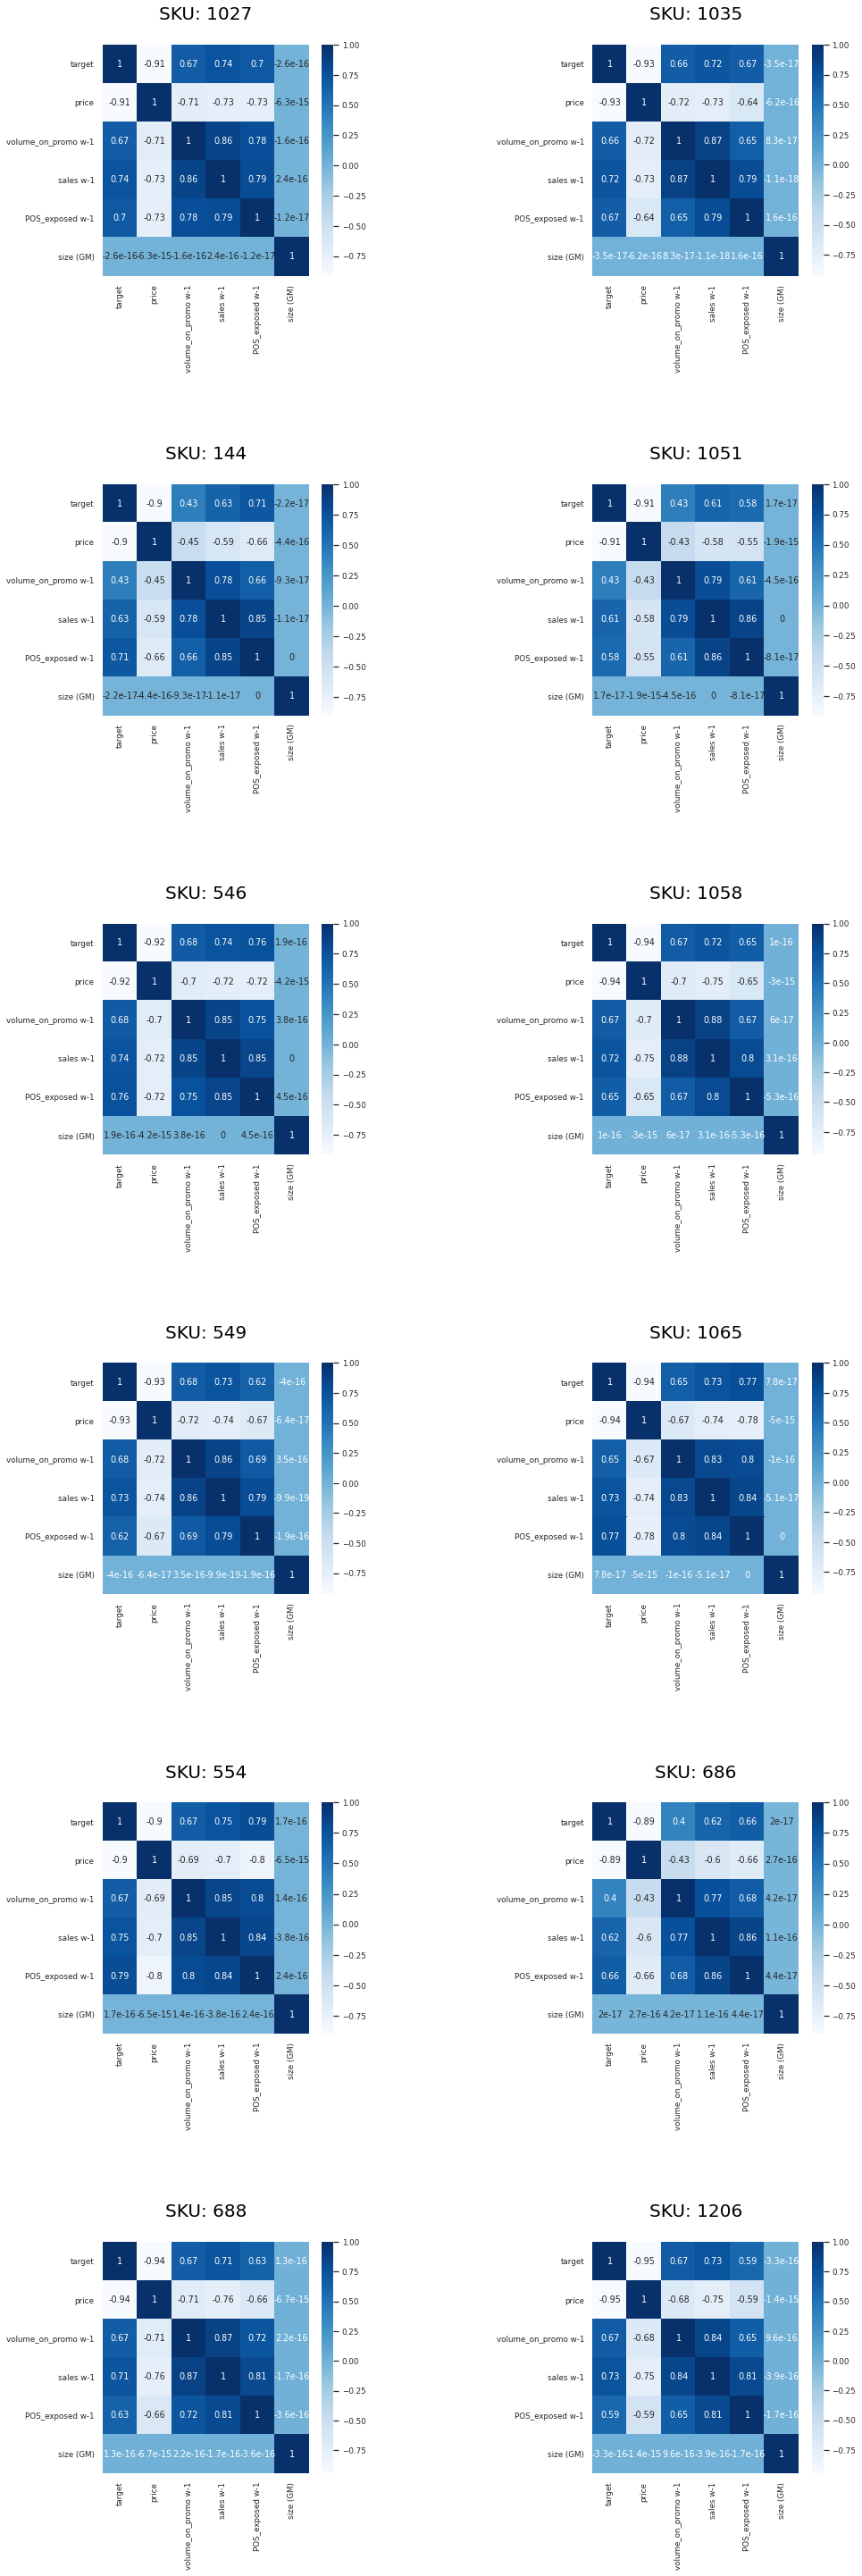

In [13]:
fig = plt.figure(figsize=(15, 50))
fig.subplots_adjust(hspace=0.9, wspace=0.9)
sns.set(font_scale=0.8)
plot_nr = 1

for sku in sales_data["sku"].unique():
  correlations = sales_data[sales_data["sku"] == sku][["target", "price", "volume_on_promo w-1", "sales w-1", "POS_exposed w-1", "size (GM)"]].corr()
  ax = fig.add_subplot(6, 2, plot_nr)
  ax.set_title("SKU: " + str(sku) + "\n", fontdict={'fontsize':20, 'color':'black'})
  sns.heatmap(correlations, cmap="Blues", annot=True, ax=ax);
  plot_nr += 1

As can be noticed, the **price** feature constitutes the most correlated feature with **target** with respect to the remaining ones. This is due to the fact that **target** and **price** refer to the same week. By the way, we can conclude that **price** is a very good feature to predict the sales for each SKU. Furthermore:
*   **Sales w-1**, for 9 SKUs out of 12, is positive correlated with **target** with a pearson coefficient $\approx$ 0.7. We are going to check if past values of sales, like **Sales w-1**, **Sales w-2**... constitute good features to predict future values of Sales (**target**) (i.e., AR-like process),
*   **POS_exposed w-1**, may influence future values of Sales since more people see that product on the previous week. By the way, the correlation is not always "strong" among different SKUs. Similarly, we can argue the correlation between **target** and **volume_on_promo w-1**. In conclusion, these features MAY provide some help in prediction, we will check these points later,
*   **size (GM)**, that is, the product weight, is not correlated for any SKU, therefore we are not going to use it for prediction.

---

Since i am predicting sales of different products (each defined by an **sku**), i am thinking to build different models, one for each **sku**. In particular, we can observe that there are no products, with the same **sku**, which have (obviously) two or more brands, but, interestingly, there are no products which share the same **sku** but have a different packaging, that is, each **sku** has a single packaging:




In [14]:
sales_data.groupby("sku")["pack"].unique()

sku
144      [MULTI]
546     [SINGLE]
549     [SINGLE]
554     [SINGLE]
686      [MULTI]
688     [SINGLE]
1027    [SINGLE]
1035    [SINGLE]
1051     [MULTI]
1058    [SINGLE]
1065    [SINGLE]
1206    [SINGLE]
Name: pack, dtype: object

By the way, if products which share the same **pack** or the same **brand** share a similar time series for **target**, we can use a single model to learn them all. Then we can use each **sku** to shift up or down the time series we learnt to correctly predict the sales for that product. We can check now if products, which share the same **pack** feature, show a similar time series of targets:

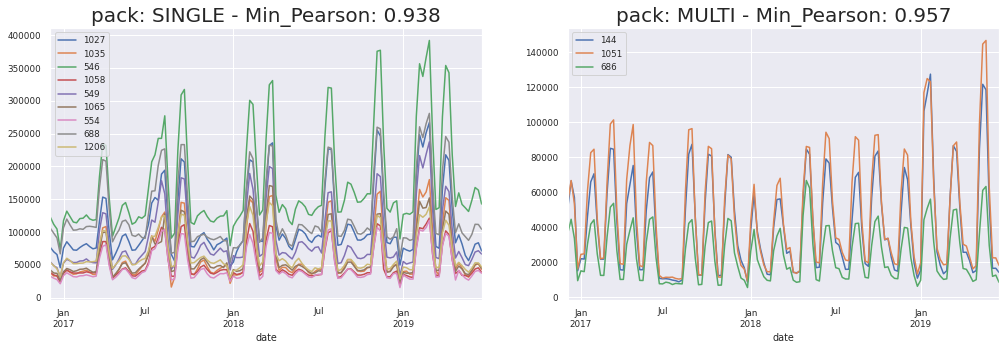

In [15]:
sales_data_multi = sales_data[sales_data["pack"] == "MULTI"]
sales_data_single = sales_data[sales_data["pack"] == "SINGLE"]
fig= plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 2, 1)
sku_combs = combinations(sales_data_single["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0]]["target"], sales_data[sales_data["sku"] == sku_comb[1]]["target"])[0])
ax.set_title("pack: SINGLE - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_single.groupby("sku")["target"].plot(ax=ax, figsize=(17, 5));
ax.legend(sales_data_single["sku"].unique())
ax = fig.add_subplot(1, 2, 2)
sku_combs = combinations(sales_data_multi["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0]]["target"], sales_data[sales_data["sku"] == sku_comb[1]]["target"])[0])
ax.set_title("pack: MULTI - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_multi.groupby("sku")["target"].plot(ax=ax, figsize=(17, 5));
ax.legend(sales_data_multi["sku"].unique());


Seemingly, products which share the same **pack** present the same sales time series, as it is shown by the minimum pearson's coefficient among all the pairs (that means, the sales of product which share the same pack present the same peaks, and also the same general behaviour). We could build a single model, one for **pack: SINGLE** products and the other for **pack:MULTI**, each model then can use the information given by the **sku** of the product we are predicting the sales to adjust the prediction, shifting it up or down. As an example, for **pack:SINGLE** we can observe that products 554 and 1058 present almost exactly the same time series, therefore the model will not discriminate so much between these two. On the other hand, the time series for product 546 can be approximated by just shifting up the 544 one. 

---

Let's perform the same analysis with **brand**, we have two different brands:

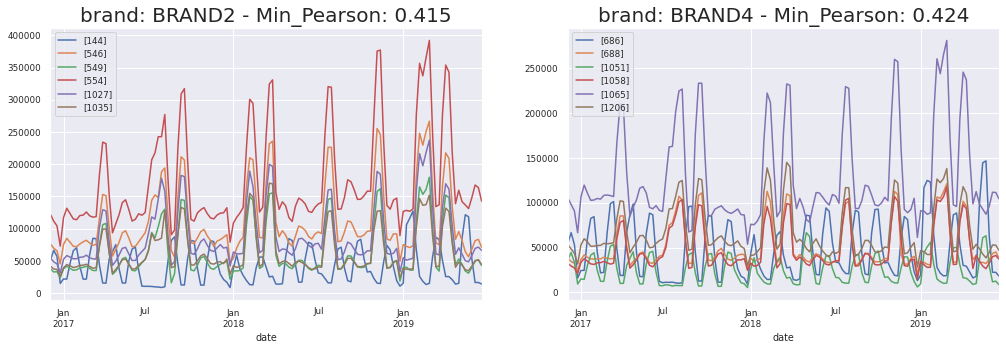

In [16]:
sales_data_brand2 = sales_data[sales_data["brand"] == "BRAND2"].groupby("sku")
sales_data_brand4 = sales_data[sales_data["brand"] == "BRAND4"].groupby("sku")
fig= plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 2, 1)
sku_combs = combinations(sales_data_brand2["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0][0]]["target"], sales_data[sales_data["sku"] == sku_comb[1][0]]["target"])[0])
ax.set_title("brand: BRAND2 - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_brand2["target"].plot(ax=ax, figsize=(17, 5))
ax.legend(sales_data_brand2["sku"].unique())
ax = fig.add_subplot(1, 2, 2)
sku_combs = combinations(sales_data_brand4["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0][0]]["target"], sales_data[sales_data["sku"] == sku_comb[1][0]]["target"])[0])
ax.set_title("brand: BRAND4 - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_brand4["target"].plot(ax=ax, figsize=(17, 5));
ax.legend(sales_data_brand4["sku"].unique());

For what concerns brands, seasonalities seems to be related, with the exception of **sku**:144 for BRAND2 and of **sku**s 686 and 1051 for BRAND4. Indeed, the seasonalities presented by the latters appears to be unrealed with the other products with the same **brand** and for this reason the minimun Pearson's coefficient drop significantly w.r.t. the previous case. For this reason, we cannot learn a model for all of those products which share the same **brand** in the same way we did for the **pack** feature.

---

Finally, we can check whether the time series of **target** are related for those products which share the same brand and the same **pack**:

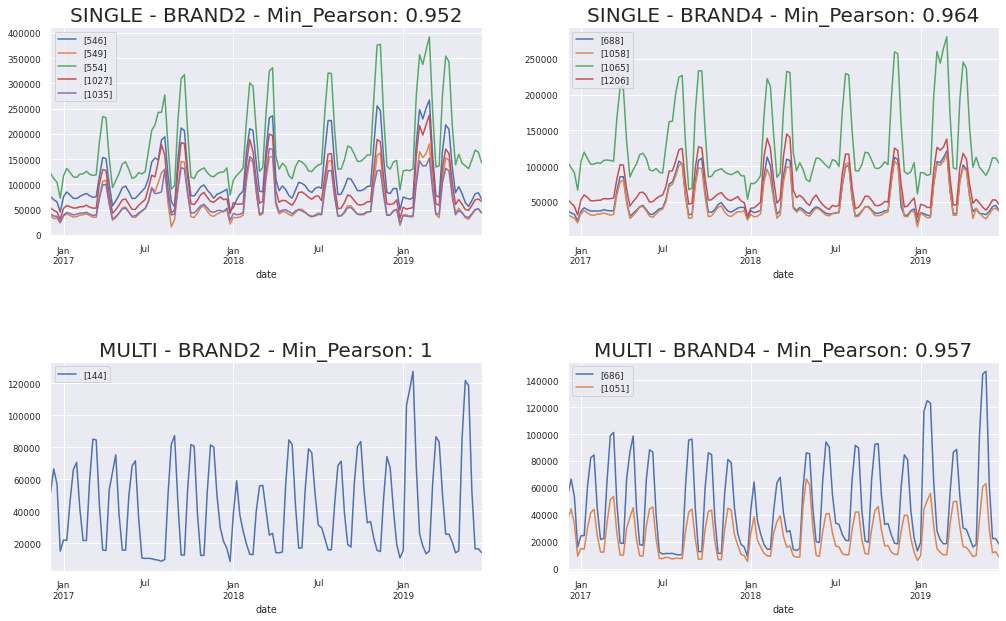

In [17]:
combs = list(combinations(["SINGLE", "MULTI", "BRAND2", "BRAND4"], 2))
feasible_combs = []
for elem in combs:
  if (elem != ("SINGLE", "MULTI")) and (elem != ("BRAND2", "BRAND4")):
    feasible_combs.append(list(elem))

fig = plt.figure(figsize=(20, 12))
fig.subplots_adjust(hspace=0.6)
index = 1

for comb in feasible_combs:
  sales_comb = sales_data[(sales_data["pack"] == comb[0]) & (sales_data["brand"] == comb[1])]
  sales_comb = sales_comb.groupby("sku")
  ax = fig.add_subplot(2, 2, index)
  sales_comb["target"].plot(ax=ax, figsize=(17, 10))
  ax.legend(sales_comb["sku"].unique())
  sku_combs = combinations(sales_comb["sku"].unique(), 2)
  pearsons_coeff = []
  for sku_comb in sku_combs:
    pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0][0]]["target"], sales_data[sales_data["sku"] == sku_comb[1][0]]["target"])[0])
  try:
    ax.set_title(comb[0] + " - " + comb[1] + " - Min_Pearson: " + str(round(np.min(pearsons_coeff), 3)) , fontdict={"fontsize":20})
  except ValueError:
    ax.set_title(comb[0] + " - " + comb[1] + " - Min_Pearson: 1" , fontdict={"fontsize":20})

  index += 1


If we would follow this separation, we will learn four different models, one for each possible combinations, since all of them show time series which are significantly related. We will determine whether learn four models (following this approach), rather than two (following the **pack** separation approach), introduce an improve of performances. In the end, we can also check whether learning a model for each product is worth it it practice.

---

From the previous plots, we can notice some products which, in general, show a single seasonality, like 144, 686 and 1051. On the other hand, products like 554 seemingly show multiple seasonalitites. Models like SARIMAX can handle a single seasonality, let's briefly analyze product 144's time series of sales before trying to apply such a model:

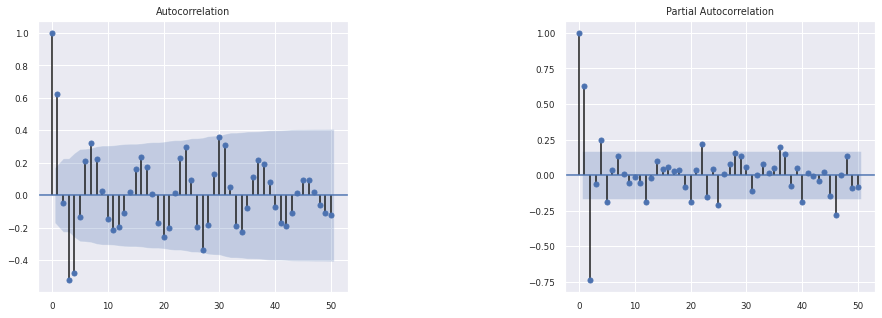

In [18]:
sales_data_144 = sales_data[sales_data["sku"] == 144]
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.7)
ax = fig.add_subplot(1, 2, 1)
plot_acf(sales_data_144["target"], ax=ax, lags=50)
ax = fig.add_subplot(1, 2, 2)
plot_pacf(sales_data_144["target"], ax=ax, lags=50)
plt.show();

From the autocorrelation and partial autocorrelation plots, it is easy to see the seasonality present in the **target** time series. We can try to use a SARIMAX model and identify the seasonal component with period equal to three, that is, three weeks. To determine the best SARIMAX parameters set, which is composed by 7 parameters, we can explore a little subset of this parameters-space and use a train/test sets:

In [91]:
models_aic = []
models_aic.sort(key=lambda x: x[1], reverse=True)
exog = np.array(sales_data_144["price"][100:]).reshape(-1, 1)
for ar in range(0, 5):
  for i in range(0, 3):
    for ma in range (0, 5):
      for ar_s in range(0, 3):
        for i_s in range(0, 2):
          for ma_s in range(0, 3):
            for m in [2, 3, 4, 5]:
              sarimax_model = SARIMAX(sales_data_144["target"][: 100], order=(ar, i, ma), seasonal_order=(ar_s, i_s, ma_s, m), exog=sales_data_144["price"][0:100])
              try:
                trained_sarimax = sarimax_model.fit()
              except Exception:
                continue
              aic = trained_sarimax.aic
              bic = trained_sarimax.bic
              predictions = trained_sarimax.predict(start=100, end=132, exog=exog)
              mape = MAPE(sales_data_144["target"][100::], predictions)
              models_aic.append([ar, i, ma, ar_s, i_s, ma_s, m, aic, bic, mape])

models_data = pd.DataFrame(models_aic, columns=["AR", "I", "MA", "AR_s", "I_s", "MA_s", "m", "AIC", "BIC", "MAPE"]).sort_values(by=["MAPE"], ascending=True)
models_data.head(10)

,AR,I,MA,AR_s,I_s,MA_s,m,AIC,BIC,MAPE
60,0,0,0,2,1,0,2,2152.081426,2162.421296,0.177
64,0,0,0,2,1,1,2,2150.515257,2163.440094,0.177
1334,1,0,3,1,1,0,4,2087.133508,2105.083945,0.179
1406,1,0,4,1,1,0,4,2086.579543,2107.094328,0.179
1292,1,0,2,2,1,2,2,2102.700586,2125.965293,0.180
4405,4,0,1,0,1,0,4,2087.812349,2105.762787,0.180
4485,4,0,2,0,1,2,4,2065.086267,2090.729749,0.181
1284,1,0,2,2,1,0,2,2110.268218,2128.362990,0.181
3406,3,0,2,0,1,2,4,2068.491653,2091.570787,0.181
4505,4,0,2,1,1,1,4,2065.217671,2090.861153,0.181


The first two model with the best performances seems to consider only the seasonal part of the model. We can use, for our purposes, the model with index **1406**:

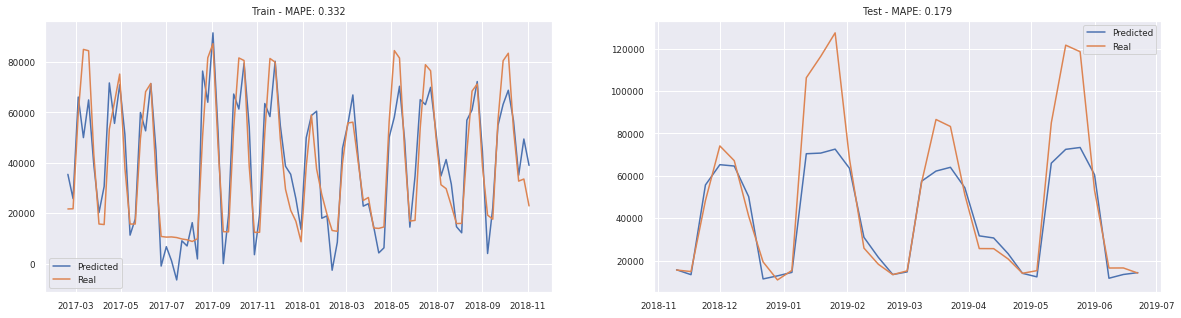

In [139]:
sarimax_model = SARIMAX(sales_data_144["target"][: 100], order=(1, 0, 4), seasonal_order=(1, 1, 0, 4), exog=sales_data_144["price"][0:100])
trained_sarimax = sarimax_model.fit()
exog = np.array(sales_data_144["price"][100:]).reshape(-1, 1)
train_predictions = trained_sarimax.predict(start=-90, exog=exog)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_predictions)
ax.plot(sales_data_144["target"][10:100])
ax.legend(["Predicted", "Real"])
mape = MAPE(sales_data_144["target"][10:100], train_predictions)
ax.set_title("Train - MAPE: " + str(mape))
predictions = trained_sarimax.predict(start=100, end=132, exog=exog)
ax = fig.add_subplot(1, 2, 2)
ax.plot(predictions)
ax.plot(sales_data_144["target"][100::])
ax.legend(["Predicted", "Real"])
mape = MAPE(sales_data_144["target"][100::], predictions)
ax.set_title("Test - MAPE: " + str(mape))
plt.show()

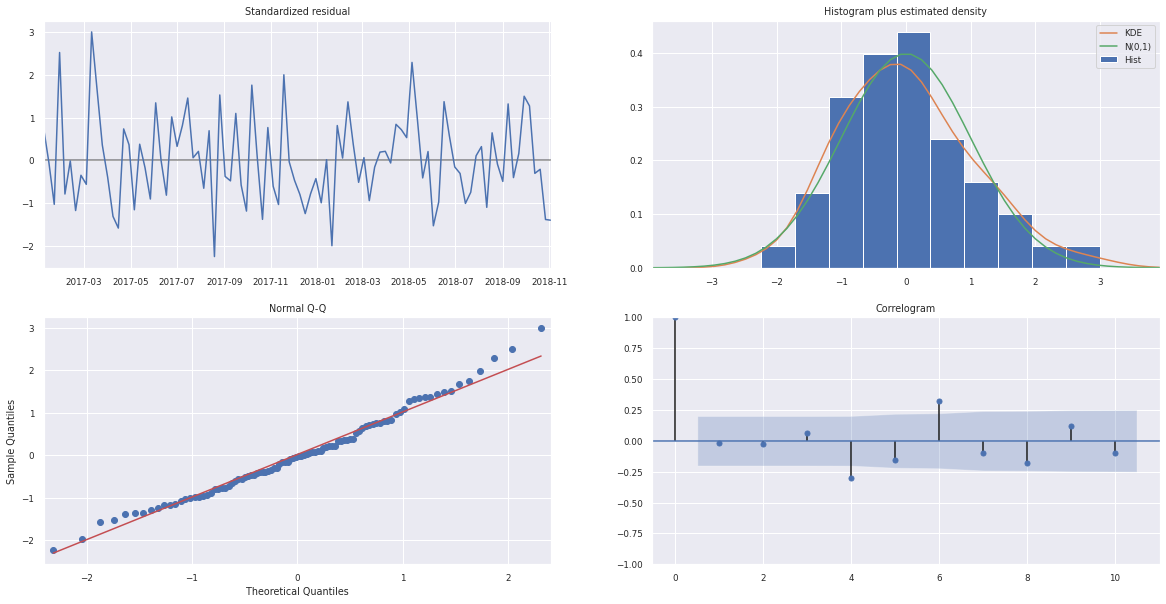

In [140]:
trained_sarimax.plot_diagnostics(figsize=(20, 10))
plt.show();

From the correlogram of the residuals, we can notice that not all the information is captured by our model, since for multiple lags the residuals appear to be correlated. Furthermore, the distribution of the residuals is clearly a non-standard normal distribution, that is, the prediction error is not a white noise. As a consequence, there may be some information left in the prediction error which is not captured by the model. 

Pay attention to the fact that the resulting parameter for I is equal to zero, as could be expected. Indeed, the adfuller test allows us to reject the hypothesis of this series to be a random walker with confidence 95%. Here's the p-value:

In [19]:
p_value = adfuller(sales_data_1027["target"])[1]
print("Adfuller p-value:", p_value)

Adfuller p-value: 3.2144757295957615e-05


Is interesting now to observe whether previous lags of the other features consitute a good set of features to predict the **target**. To do so, we can first add the past five (but it can be more) lags  of each feature, then fit a Lasso model that will give us help in terms of features selection.

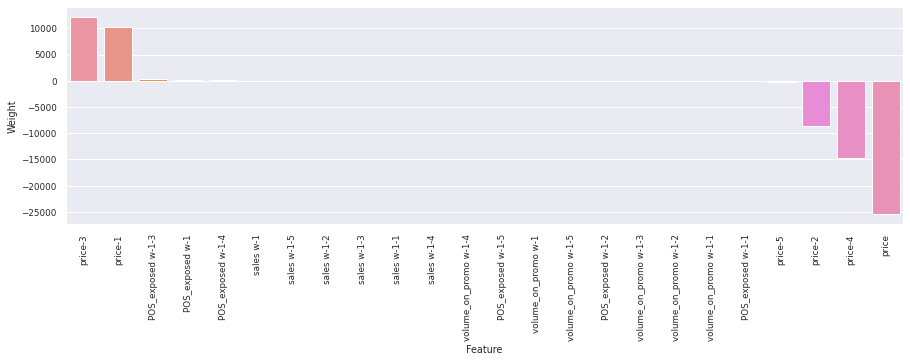

In [20]:
# add previous lags of all the numeric features, except for size (GM), that is useless for our purposes
for feature in ["price", "POS_exposed w-1", "volume_on_promo w-1", "sales w-1"]:
  for lag in range(1, 6):
    sales_data_144[feature + "-" + str(lag)] = sales_data_144[feature].shift(lag)

sales_data_144.dropna(inplace=True)
selected_features = []
for column in sales_data_144.columns:
  if (column != "sku") and (column != "target") and (column != "size (GM)") and \
     (column != "brand") and (column != "pack") and (column != "scope"):
     selected_features.append(column)
selected_features.sort(reverse=False)

lasso_model = Lasso(alpha=0.001, max_iter=5000, random_state=12323)
lasso_model.fit(X=sales_data_144[selected_features], y=sales_data_144["target"])
lr_coefficients = pd.DataFrame({'Variable':selected_features, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
plt.figure(figsize=(15, 4))
sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Weight");

It seems that only the **price** feature, with all its lags, is relevant feature selection-wise. Actually, as already discussed, **price** constitutes a really good predictive feature; the reason why **price** got the highest weights is because the range of **price** values is (1.75, 3.89) (as can be verified by using the proper pandas' methods) whereas the **target** values' range is (8653, 127418). Therefore, to predict **target** the model has to assign high weights to **price** lags. On the contrary, to feature like **sales w-1**, which has the same scale as **target**, lower weights are assigned, but this fact does not mean that **price w-1** is not important in the prediction. To have a clearer vision of the features' contributes to prediction, let's normalize the data-set:

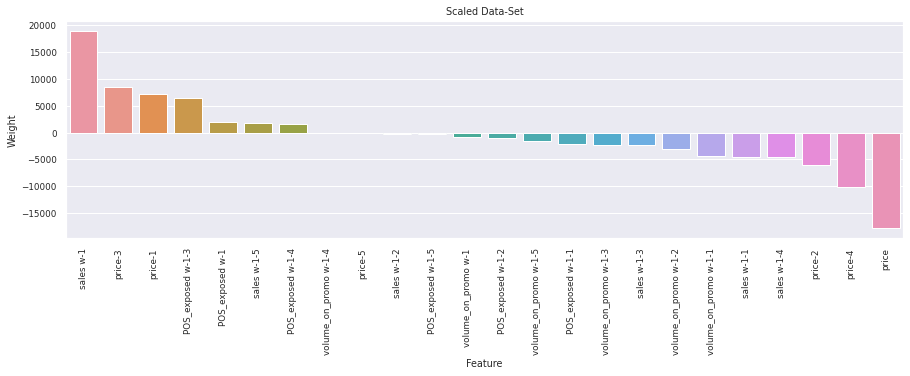

In [21]:
std_scaler = StandardScaler()
scaled_sales_data_144 = std_scaler.fit_transform(X=sales_data_144[selected_features])

# fit a new Lasso model for features selection with the normalize data frame
lasso_model = Lasso(alpha=0.001, max_iter=5000, random_state=12323)
lasso_model.fit(X=scaled_sales_data_144, y=sales_data_144["target"])
lr_coefficients = pd.DataFrame({'Variable':selected_features, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
plt.figure(figsize=(15, 4))
sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.title("Scaled Data-Set")
plt.ylabel("Weight");

Here we have a more clear vision of the contributions of all the features. We can try to train our first linear model, considering only those features which have a weight that is higher, in module, than a given threshold $\delta$ in the previous analysis. Let's try with different values of $\delta$ with a train, validation and test approach:

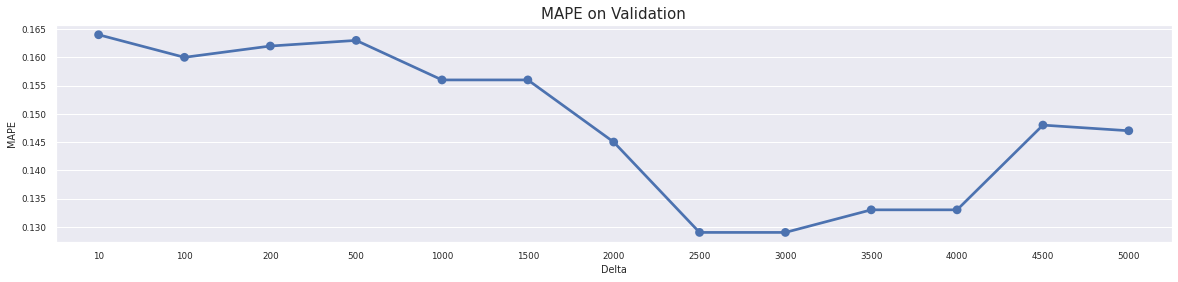

In [95]:
deltas = [10, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
mape_on_validation = []
for delta in deltas:
  delta_features = lr_coefficients[(lr_coefficients["Coefficient"] > delta) | (lr_coefficients["Coefficient"] < -delta)]["Variable"]
  lasso_model = Lasso(alpha=0.01)
  lasso_model.fit(X=sales_data_144[delta_features][0:77], y=sales_data_144["target"][0:77])
  predictions = lasso_model.predict(sales_data_144[delta_features][77:102])
  mape = MAPE(sales_data_144["target"][77:102], predictions)
  mape_on_validation.append([delta, mape])

delta_performance = pd.DataFrame(mape_on_validation, columns=["Delta", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(20, 4))
plt.title("MAPE on Validation", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data= delta_performance);

We can choose the best result we obtained, that is the model fed with the set of features determined by $\delta=2500$ and check the performances on the test set:

In [107]:
best_delta = 2500
delta_features = lr_coefficients[(lr_coefficients["Coefficient"] > best_delta) | (lr_coefficients["Coefficient"] < -best_delta)]["Variable"]
lasso_model = Lasso(alpha=0.01, random_state=12345)
lasso_model.fit(X=sales_data_144[delta_features][0:102], y=sales_data_144["target"][0:102])
predictions_degree_1 = lasso_model.predict(sales_data_144[delta_features][102:127])
mape = MAPE(sales_data_144["target"][102:127], predictions_degree_1)
print("MAPE on Test-Set:", mape)

MAPE on Test-Set: 0.198


Let's try to improve the performances of our model by feeding it with non-linear input-features:

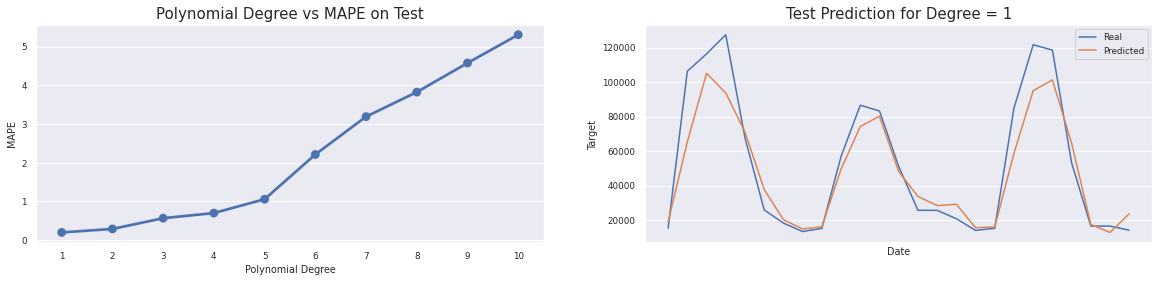

In [116]:
degree_mape = []
for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
  poly_tranformer = PolynomialFeatures(degree=degree)
  poly_data = poly_tranformer.fit_transform(sales_data_144[delta_features])
  lasso_model = Lasso(alpha=0.1)
  lasso_model.fit(X=poly_data[0:102], y=sales_data_144["target"][0:102])
  predictions = lasso_model.predict(X=poly_data[102:127])
  mape = MAPE(sales_data_144["target"][102:127], predictions)
  degree_mape.append([degree, mape])

delta_mape_frame = pd.DataFrame(degree_mape, columns=["Polynomial Degree", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Polynomial Degree vs MAPE on Test", fontdict={"fontsize":15})
sns.pointplot(x="Polynomial Degree", y="MAPE", data=delta_mape_frame, ax=ax)
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Test Prediction for Degree = 1", fontdict={"fontsize":15})
ax.plot(sales_data_144["target"][102:127].values)
ax.plot(predictions_degree_1)
ax.set_xlabel("Date")
ax.set_ylabel("Target")
ax.legend(["Real", "Predicted"])
ax.set_xticks([])
plt.show()